In [1410]:
from datetime import datetime as d

import numpy as np
from numpy import linalg
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import math as m
np.set_printoptions(precision=4, suppress=True)

import math

# Outline (As recommended by 538's 2016 Election Model)
_Link:_ https://fivethirtyeight.com/features/a-users-guide-to-fivethirtyeights-2016-general-election-forecast/

1) Collect, weight and average polls. 

2) Adjust polls for current trends and house effects.

3) Combine polls with demographic data through regression analysis to produce an electoral snapshot. 

_Sources:_
- https://github.com/jseabold/538model/blob/master/silver_model.ipynb
- https://github.com/benjones4747/silver/tree/5841d9a76ce78330c4ef701a3cc12a9e50097fdd/lib


## Step 1: Collect, Weight, and Average the Polls

#### Polls

In [1411]:
#gathers polls from 538
poll = pd.read_csv('Relevant_Data/2020/president_polls.csv')
poll.head(5)

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,nationwide_batch,ranked_choice_reallocated,created_at,notes,url,stage,answer,candidate_name,candidate_party,pct
0,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,False,False,4/6/20 06:09,NaN,https://www.unf.edu/uploadedFiles/aa/coas/porl...,general,Biden,Joseph R. Biden Jr.,DEM,46.0
1,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,False,False,4/6/20 06:09,NaN,https://www.unf.edu/uploadedFiles/aa/coas/porl...,general,Trump,Donald Trump,REP,40.0
2,120728,65060,2020,Michigan,383,Public Policy Polling,338,Progress Michigan,Public Policy Polling,263.0,...,False,False,4/2/20 16:57,NaN,https://progressmichigan.org/wp-content/upload...,general,Biden,Joseph R. Biden Jr.,DEM,48.0
3,120728,65060,2020,Michigan,383,Public Policy Polling,338,Progress Michigan,Public Policy Polling,263.0,...,False,False,4/2/20 16:57,NaN,https://progressmichigan.org/wp-content/upload...,general,Trump,Donald Trump,REP,45.0
4,120899,65227,2020,Georgia,1549,Battleground Connect,NaN,NaN,Battleground Connect,NaN,...,False,False,4/3/20 11:04,NaN,https://projects.fivethirtyeight.com/polls/202...,general,Biden,Joseph R. Biden Jr.,DEM,46.0


In [1412]:
poll = poll[(poll['candidate_name'] == 'Joseph R. Biden Jr.') | (poll['candidate_name'] == 'Donald Trump')]
poll

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,nationwide_batch,ranked_choice_reallocated,created_at,notes,url,stage,answer,candidate_name,candidate_party,pct
0,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,False,False,4/6/20 06:09,NaN,https://www.unf.edu/uploadedFiles/aa/coas/porl...,general,Biden,Joseph R. Biden Jr.,DEM,46.0
1,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,False,False,4/6/20 06:09,NaN,https://www.unf.edu/uploadedFiles/aa/coas/porl...,general,Trump,Donald Trump,REP,40.0
2,120728,65060,2020,Michigan,383,Public Policy Polling,338,Progress Michigan,Public Policy Polling,263.0,...,False,False,4/2/20 16:57,NaN,https://progressmichigan.org/wp-content/upload...,general,Biden,Joseph R. Biden Jr.,DEM,48.0
3,120728,65060,2020,Michigan,383,Public Policy Polling,338,Progress Michigan,Public Policy Polling,263.0,...,False,False,4/2/20 16:57,NaN,https://progressmichigan.org/wp-content/upload...,general,Trump,Donald Trump,REP,45.0
4,120899,65227,2020,Georgia,1549,Battleground Connect,NaN,NaN,Battleground Connect,NaN,...,False,False,4/3/20 11:04,NaN,https://projects.fivethirtyeight.com/polls/202...,general,Biden,Joseph R. Biden Jr.,DEM,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4069,92080,57026,2020,Ohio,383,Public Policy Polling,918,DEM,Public Policy Polling,263.0,...,False,False,12/6/18 14:43,NaN,https://www.cleveland.com/politics/2018/11/thi...,general,Biden,Joseph R. Biden Jr.,DEM,48.0
4070,92080,57026,2020,Ohio,383,Public Policy Polling,918,DEM,Public Policy Polling,263.0,...,False,False,12/6/18 14:43,NaN,https://www.cleveland.com/politics/2018/11/thi...,general,Trump,Donald Trump,REP,44.0
4072,92081,57026,2020,Ohio,383,Public Policy Polling,918,DEM,Public Policy Polling,263.0,...,False,False,12/6/18 14:45,NaN,https://www.cleveland.com/politics/2018/11/thi...,general,Trump,Donald Trump,REP,46.0
4074,92082,57026,2020,Ohio,383,Public Policy Polling,918,DEM,Public Policy Polling,263.0,...,False,False,12/6/18 14:46,NaN,https://www.cleveland.com/politics/2018/11/thi...,general,Trump,Donald Trump,REP,49.0


#### Calculating Weighted Average (Recency, Pollster Rating, Sample Size)

In [1413]:
pollster_weights = pd.read_csv('2018_Pollster_Rating - Sheet1.csv')
pollster_weights.head(5)

,Pollster,# of Polls,NCPP / AAPOR / Roper,Exclusively Live Caller With Cellphones,Methodology,Banned by 538,Historical Advanced Plus-Minus,Predictive Plus-Minus,538 Grade,Mean-Reverted Bias,...,Simple Average Error,Simple Expected Error,Simple Plus-Minus,Advanced Plus-Minus,Mean-Reverted Advanced Plus Minus,Predictive Plus-Minus,# of Polls for Bias Analysis,Bias,Mean-Reverted Bias.1,House Effect
0,Selzer & Co.,43,yes,yes,Live,no,-1.9,-1.4,A+,R +0.0,...,4.2,5.6,-1.4,-1.9,-1.1,-1.4,30,R +0.0,R +0.0,D +0.1
1,Monmouth University,95,yes,yes,Live,no,-1.5,-1.3,A+,D +1.4,...,5.3,6.2,-0.8,-1.5,-1.1,-1.3,65,D +2.1,D +1.4,R +0.7
2,Field Research Corp. (Field Poll),25,yes,yes,Live,no,-2.5,-1.1,A+,R +1.2,...,3.9,5.7,-1.8,-2.5,-1.1,-1.1,18,R +3.3,R +1.2,D +0.6
3,ABC News/Washington Post,60,yes,yes,Live,no,-1.3,-1.1,A+,D +0.6,...,2.9,4.6,-1.8,-1.3,-0.9,-1.1,55,D +0.9,D +0.6,D +1.5
4,Elway Research,21,yes,yes,Live,no,-2.2,-1.1,A+,D +0.5,...,3.9,5.9,-1.9,-2.2,-0.9,-1.1,20,D +1.2,D +0.5,D +3.2


In [1414]:
#HELPER FUNCTION 
def month(value):
    return value[0]

def year(value):
    return value[-2:]

In [1415]:
polls = pd.merge(poll, pollster_weights, left_on = "pollster", right_on = "Pollster")
#for i in polls.columns:
    #print(i)

In [1416]:
# Recency (most recent: 4/5/20)
# Need to use exponential decay to compare the polling time to the election date
# Caveat: Being farther out from election day makes polls kind of useless
# Our code predicts if the elections were to happen on April 5th, 2020

def exp_decay(days):
    days = getattr(days, "days", days)
    return .5 ** (days/30.)

def ageweight(raw):
    raw['age_weight'] = 0.0
    for index, row in raw.iterrows():
        d0 = ('4/5/20')
        d0 = d.strptime(d0, '%m/%d/%y')
        date = row['end_date']
        d1 = d.strptime(date, '%m/%d/%y')
        delta = d0 - d1
        diff = delta.days
        age_weight = exp_decay(diff)
        raw.at[index,'recency_weight'] = age_weight
    return

ageweight(polls)

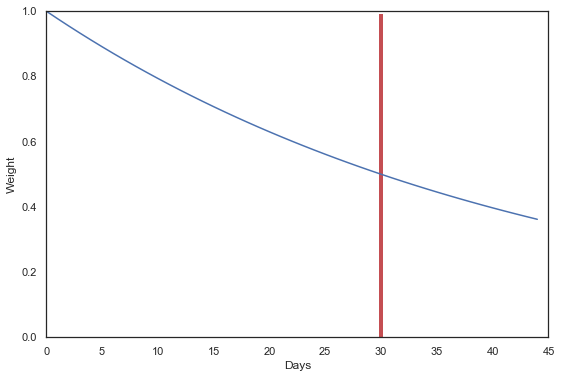

In [1417]:
fig, ax = plt.subplots(figsize=(9,6), subplot_kw={"xlabel" : "Days",
                                                   "ylabel" : "Weight"})
days = np.arange(0, 45)
ax.plot(days, exp_decay(days));
ax.vlines(30, 0, .99, color='r', linewidth=4)
ax.set_ylim(0,1)
ax.set_xlim(0, 45);

In [1418]:
polls[['end_date','recency_weight']]

,end_date,recency_weight
0,4/4/20,0.977160
1,4/4/20,0.977160
2,2/18/20,0.337587
3,2/18/20,0.337587
4,2/18/20,0.337587
...,...,...
1680,4/18/19,0.000287
1681,4/18/19,0.000287
1682,1/21/19,0.000038
1683,1/21/19,0.000038


In [1419]:
# Pollster Rating
def weight(x):
    #i think this weight i based on the 2016 elections
    newx = float(1 - (1/(3.025044 + 1.200763)) * (x + 1.200763))
    return newx

def apply_weights(pr):
    pr['pollster_weight'] = 0.0
    for index, row in pr.iterrows():
        x = row['Predictive Plus-Minus']
        if row['Banned by 538'] == 'yes':
            newx = 0.0
        else:
            newx = weight(x)
        pr.at[index,'pollster_weight'] = newx
    return pr

In [1420]:
apply_weights(polls)

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,Advanced Plus-Minus,Mean-Reverted Advanced Plus Minus,Predictive Plus-Minus,# of Polls for Bias Analysis,Bias,Mean-Reverted Bias.1,House Effect,age_weight,recency_weight,pollster_weight
0,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506
1,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506
2,118575,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506
3,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506
4,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1680,94190,57932,2020,Wisconsin,495,Tulchin Research,NaN,NaN,Tulchin Research,340.0,...,-3.0,-0.2,0.2,2,R +3.5,R +0.2,D +3.2,0.0,0.000287,0.668522
1681,94191,57933,2020,Pennsylvania,495,Tulchin Research,NaN,NaN,Tulchin Research,340.0,...,-3.0,-0.2,0.2,2,R +3.5,R +0.2,D +3.2,0.0,0.000287,0.668522
1682,92872,57407,2020,New Hampshire,1304,Praecones Analytica,645,New Hampshire Journal,Praecones Analytica,257.0,...,-4.7,-0.4,0.5,3,R +1.8,R +0.2,R +5.3,0.0,0.000038,0.597529
1683,92873,57407,2020,New Hampshire,1304,Praecones Analytica,645,New Hampshire Journal,Praecones Analytica,257.0,...,-4.7,-0.4,0.5,3,R +1.8,R +0.2,R +5.3,0.0,0.000038,0.597529


In [1421]:
# Sample size (based on how Nate Silver used it in 2008)
mean = np.mean(polls['sample_size'])
polls['sample_size_weight'] = (polls['sample_size']/mean)**0.5
polls[['sample_size', 'sample_size_weight']]

,sample_size,sample_size_weight
0,3244.0,1.466921
1,3244.0,1.466921
2,672.0,0.667653
3,668.0,0.665663
4,668.0,0.665663
...,...,...
1680,400.0,0.515106
1681,400.0,0.515106
1682,593.0,0.627182
1683,593.0,0.627182


In [1422]:
# Get weighted averages
polls['weighted_average'] = polls['recency_weight'] * polls['pollster_weight'] * polls['sample_size_weight']

def weighted_average(df):
    weights1 = df['recency_weight']
    weights2 = df['pollster_weight']
    weights3 = df['sample_size_weight']
    return weights1*weights2*weights3
    
state_polls = polls.groupby(['state', 'pollster']).apply(weighted_average)

In [1423]:
polls.head(5)

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,Predictive Plus-Minus,# of Polls for Bias Analysis,Bias,Mean-Reverted Bias.1,House Effect,age_weight,recency_weight,pollster_weight,sample_size_weight,weighted_average
0,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506,1.466921,1.161794
1,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506,1.466921,1.161794
2,118575,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.667653,0.182681
3,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.665663,0.182137
4,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.665663,0.182137


In [1424]:
polls

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,Predictive Plus-Minus,# of Polls for Bias Analysis,Bias,Mean-Reverted Bias.1,House Effect,age_weight,recency_weight,pollster_weight,sample_size_weight,weighted_average
0,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506,1.466921,1.161794
1,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506,1.466921,1.161794
2,118575,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.667653,0.182681
3,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.665663,0.182137
4,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.665663,0.182137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1680,94190,57932,2020,Wisconsin,495,Tulchin Research,NaN,NaN,Tulchin Research,340.0,...,0.2,2,R +3.5,R +0.2,D +3.2,0.0,0.000287,0.668522,0.515106,0.000099
1681,94191,57933,2020,Pennsylvania,495,Tulchin Research,NaN,NaN,Tulchin Research,340.0,...,0.2,2,R +3.5,R +0.2,D +3.2,0.0,0.000287,0.668522,0.515106,0.000099
1682,92872,57407,2020,New Hampshire,1304,Praecones Analytica,645,New Hampshire Journal,Praecones Analytica,257.0,...,0.5,3,R +1.8,R +0.2,R +5.3,0.0,0.000038,0.597529,0.627182,0.000014
1683,92873,57407,2020,New Hampshire,1304,Praecones Analytica,645,New Hampshire Journal,Praecones Analytica,257.0,...,0.5,3,R +1.8,R +0.2,R +5.3,0.0,0.000038,0.597529,0.627182,0.000014


In [1425]:
polls['state'].unique()

array(['Florida', 'Michigan', 'California', 'Wisconsin', 'Kansas',
       'Maine', 'Arizona', 'Iowa', 'Washington', 'Maine CD-1',
       'Maine CD-2', 'Ohio', 'North Carolina', nan, 'Texas',
       'Pennsylvania', 'South Carolina', 'New York', 'New Mexico',
       'New Hampshire', 'Nevada', 'Colorado', 'Massachusetts', 'Georgia',
       'North Dakota', 'Minnesota', 'Mississippi', 'Alabama', 'Tennessee',
       'Virginia', 'Missouri', 'New Jersey', 'Oklahoma', 'Delaware',
       'Alaska', 'Kentucky', 'Utah'], dtype=object)

In [1426]:
rep_points = []
dem_points = []
for i in polls['state'].unique():
    start = polls[polls['state'] == i]
    for j in start['pollster'].unique():
        mid = start[start['pollster'] == j]
        mid = mid.sort_values(by = 'end_date').reset_index(drop=True)
        rep = mid[mid['candidate_name'] == 'Donald Trump'].reset_index(drop=True)
        dem = mid[mid['candidate_name'] == 'Joseph R. Biden Jr.'].reset_index(drop=True)
        if len(rep) > 1:
            rep_points.append([i,j,((rep.loc[0]['pct'] - rep.loc[len(rep)-1]['pct'])*(-1))])
        elif len(rep) == 1:
            rep_points.append([i,j,0])
        if len(dem) > 1:
            dem_points.append([i,j,(dem.loc[0]['pct'] - dem.loc[len(dem)-1]['pct'])])
        elif len(dem) == 1:
            dem_points.append([i,j,0])

In [1427]:
loess_df_1 = polls.copy()
loess_df_1['spread'] = "NAN " + str(0)

for i in rep_points: 
    loess_df_1.loc[(loess_df_1.state == i[0]) & (loess_df_1['pollster'] == i[1]),'spread'] = ("REP " + str(i[2]))
    
for i in dem_points: 
    loess_df_1.loc[(loess_df_1.state == i[0]) & (loess_df_1['pollster'] == i[1]),'spread'] = ("DEM " + str(i[2]))

polls = loess_df_1.reset_index(drop=True)
polls

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,# of Polls for Bias Analysis,Bias,Mean-Reverted Bias.1,House Effect,age_weight,recency_weight,pollster_weight,sample_size_weight,weighted_average,spread
0,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506,1.466921,1.161794,DEM 2.0
1,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506,1.466921,1.161794,DEM 2.0
2,118575,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.667653,0.182681,DEM 2.0
3,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.665663,0.182137,DEM 2.0
4,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.665663,0.182137,DEM 2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1680,94190,57932,2020,Wisconsin,495,Tulchin Research,NaN,NaN,Tulchin Research,340.0,...,2,R +3.5,R +0.2,D +3.2,0.0,0.000287,0.668522,0.515106,0.000099,REP 0
1681,94191,57933,2020,Pennsylvania,495,Tulchin Research,NaN,NaN,Tulchin Research,340.0,...,2,R +3.5,R +0.2,D +3.2,0.0,0.000287,0.668522,0.515106,0.000099,REP 0
1682,92872,57407,2020,New Hampshire,1304,Praecones Analytica,645,New Hampshire Journal,Praecones Analytica,257.0,...,3,R +1.8,R +0.2,R +5.3,0.0,0.000038,0.597529,0.627182,0.000014,REP -0.5
1683,92873,57407,2020,New Hampshire,1304,Praecones Analytica,645,New Hampshire Journal,Praecones Analytica,257.0,...,3,R +1.8,R +0.2,R +5.3,0.0,0.000038,0.597529,0.627182,0.000014,REP -0.5


## Step 2: Adjust polls

* Trend line adjustment 

In [1428]:
pvi = pd.read_csv("Relevant_Data/2020/fivethirtyeight_partisan_lean_STATES copy.csv")
pvi.head()

,state,pvi_538
0,Alabama,R+27
1,Alaska,R+15
2,Arizona,R+9
3,Arkansas,R+24
4,California,D+24


In [1429]:
pvi.set_index("state", inplace=True);
pvi.head()

,pvi_538
state,
Alabama,R+27
Alaska,R+15
Arizona,R+9
Arkansas,R+24
California,D+24


In [1430]:
pvi.columns = ['PVI']
pvi.head()

,PVI
state,
Alabama,R+27
Alaska,R+15
Arizona,R+9
Arkansas,R+24
California,D+24


In [1431]:
pvi.PVI = pvi.PVI.replace({"EVEN" : "0"})
pvi.PVI = pvi.PVI.str.replace("R\+", "-")
pvi.PVI = pvi.PVI.str.replace("D\+", "")
pvi.PVI = pvi.PVI.astype(float)
pvi.PVI

state
Alabama          -27.0
Alaska           -15.0
Arizona           -9.0
Arkansas         -24.0
California        24.0
Colorado           1.0
Connecticut       11.0
Delaware          14.0
Florida           -5.0
Georgia          -12.0
Hawaii            36.0
Idaho            -35.0
Illinois          13.0
Indiana          -18.0
Iowa              -6.0
Kansas           -23.0
Kentucky         -23.0
Louisiana        -17.0
Maine              5.0
Maryland          23.0
Massachusetts     29.0
Michigan           1.0
Minnesota          2.0
Mississippi      -15.0
Missouri         -19.0
Montana          -18.0
Nebraska         -24.0
Nevada            -1.0
New Hampshire     -2.0
New Jersey        13.0
New Mexico         7.0
New York          22.0
North Carolina    -5.0
North Dakota     -33.0
Ohio              -7.0
Oklahoma         -34.0
Oregon             9.0
Pennsylvania      -1.0
Rhode Island      26.0
South Carolina   -17.0
South Dakota     -31.0
Tennessee        -28.0
Texas            -17.0
Utah 

In [1432]:
party_affil = pd.read_csv("party_affiliation_by_state.csv")
party_affil =party_affil.rename(columns={'Unnamed: 0': "State", 'Democrat/Lean Democratic': 'Democrat', 
                           'Republican/Lean Republican': 'Republican', 
                            'Democratic advantage':'Dem_Adv'}).set_index("State")[1:53]
party_affil

,Democrat,Republican,Dem_Adv,N,Classification
State,,,,,
U.S.,45,38,7,"180,106",Lean Dem
Maine,47,39,8,941,Lean Dem
New Hampshire,43,40,3,831,Competitive
Vermont,52,30,22,496,Solid Dem
Massachusetts,57,26,31,"3,805",Solid Dem
Rhode Island,48,27,21,602,Solid Dem
Connecticut,51,32,19,"2,020",Solid Dem
New York,52,29,23,"10,864",Solid Dem
New Jersey,48,33,15,"4,455",Solid Dem


In [1433]:
party_affil.columns

Index(['Democrat', 'Republican', 'Dem_Adv', 'N', 'Classification'], dtype='object')

In [1434]:
party_affil['Democrat'] = party_affil.Democrat.str.replace("%", "").astype(float)
party_affil.Republican = party_affil.Republican.str.replace("%", "").astype(float)
party_affil["no_party"] = 100 - party_affil.Democrat - party_affil.Republican
party_affil

,Democrat,Republican,Dem_Adv,N,Classification,no_party
State,,,,,,
U.S.,45.0,38.0,7,"180,106",Lean Dem,17.0
Maine,47.0,39.0,8,941,Lean Dem,14.0
New Hampshire,43.0,40.0,3,831,Competitive,17.0
Vermont,52.0,30.0,22,496,Solid Dem,18.0
Massachusetts,57.0,26.0,31,"3,805",Solid Dem,17.0
Rhode Island,48.0,27.0,21,602,Solid Dem,25.0
Connecticut,51.0,32.0,19,"2,020",Solid Dem,17.0
New York,52.0,29.0,23,"10,864",Solid Dem,19.0
New Jersey,48.0,33.0,15,"4,455",Solid Dem,19.0


In [1435]:
#Census
census_data = pd.read_csv("Census_Data.csv")
census_data.head()

,State,Total_Pop_2019,Under_18,Over_65,Black,Native American,Hispanic,Non-Hispanic,High_School_Grad,Bachelor_Degree,Per_Capita_Income,Median_Household_Income_2018,Pop_Per_Sq_Mile_2010
0,Alabama,"4,903,185",22.30%,16.90%,26.80%,0.70%,4.40%,65.40%,85.80%,24.90%,"$26,846","$48,486",94.4
1,Alaska,"731,545",24.90%,11.80%,3.80%,15.40%,7.20%,60.30%,92.70%,29.20%,"$35,874","$76,715",1.2
2,Arizona,"7,278,717",22.90%,17.50%,5.10%,5.30%,31.60%,54.40%,86.80%,28.90%,"$29,265","$56,213",56.3
3,Arkansas,"3,017,804",23.30%,17.00%,15.70%,1.00%,7.70%,72.20%,86.20%,22.60%,"$25,635","$45,726",56
4,California,"39,512,223",22.70%,14.30%,6.50%,1.60%,39.30%,36.80%,82.90%,33.30%,"$35,021","$71,228",239.1


In [1436]:
census_refined = pd.DataFrame({})

census_data.rename(columns={
                        "Median_Household_Income_2018" : "median_income",
                        "Per_Capita_Income" : "average_income",
                        "Pop_Per_Sq_Mile_2010" : "pop_density",
                        "High_School_Grad" : "educ_hs",
                        "Bachelor_Degree" : "educ_coll",
                        "Non-Hispanic " : "per_white",
                        "Hispanic" : "per_hisp",
                        "State" : "state",
                        "Black" : "per_black",
                                }, inplace=True)

census_data.head(5)

,state,Total_Pop_2019,Under_18,Over_65,per_black,Native American,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density
0,Alabama,"4,903,185",22.30%,16.90%,26.80%,0.70%,4.40%,65.40%,85.80%,24.90%,"$26,846","$48,486",94.4
1,Alaska,"731,545",24.90%,11.80%,3.80%,15.40%,7.20%,60.30%,92.70%,29.20%,"$35,874","$76,715",1.2
2,Arizona,"7,278,717",22.90%,17.50%,5.10%,5.30%,31.60%,54.40%,86.80%,28.90%,"$29,265","$56,213",56.3
3,Arkansas,"3,017,804",23.30%,17.00%,15.70%,1.00%,7.70%,72.20%,86.20%,22.60%,"$25,635","$45,726",56
4,California,"39,512,223",22.70%,14.30%,6.50%,1.60%,39.30%,36.80%,82.90%,33.30%,"$35,021","$71,228",239.1


In [1437]:
tot_pop = census_data["Total_Pop_2019"].str.replace(",","").astype(float)
per_18 = census_data["Under_18"].str.strip('%').astype(float)/100 # under 18
per_65 = census_data["Over_65"].str.strip('%').astype(float)/100 # over 65
older_pop = per_65*tot_pop
vote_pop = tot_pop - per_18*tot_pop - older_pop
census_data["vote_pop"] = vote_pop
census_data["older_pop"] = older_pop
census_data["per_older"] = older_pop / tot_pop
census_data["per_vote"] = vote_pop / tot_pop


del census_data["Total_Pop_2019"]
del census_data["Under_18"]
del census_data["Over_65"]
del census_data["Native American"]

In [1438]:
columns = ['per_black', 'per_hisp', 'per_white', 'educ_hs', 'educ_coll']
columns_1 = ['average_income', 'median_income']

for i in columns:
    census_data[i] = census_data[i].str.strip('%').astype(float)
    
for i in columns_1:
    census_data[i] = census_data[i].str.strip('$')
    census_data[i] = census_data[i].str.replace(',','').astype(float)

In [1439]:
census_data.head()

,state,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote
0,Alabama,26.8,4.4,65.4,85.8,24.9,26846.0,48486.0,94.4,2.981136e+06,828638.265,0.169,0.608
1,Alaska,3.8,7.2,60.3,92.7,29.2,35874.0,76715.0,1.2,4.630680e+05,86322.310,0.118,0.633
2,Arizona,5.1,31.6,54.4,86.8,28.9,29265.0,56213.0,56.3,4.338115e+06,1273775.475,0.175,0.596
3,Arkansas,15.7,7.7,72.2,86.2,22.6,25635.0,45726.0,56,1.801629e+06,513026.680,0.170,0.597
4,California,6.5,39.3,36.8,82.9,33.3,35021.0,71228.0,239.1,2.489270e+07,5650247.889,0.143,0.630


In [1440]:
census_data.set_index("state", inplace=True)

In [1441]:
census_data.head()

,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote
state,,,,,,,,,,,,
Alabama,26.8,4.4,65.4,85.8,24.9,26846.0,48486.0,94.4,2.981136e+06,828638.265,0.169,0.608
Alaska,3.8,7.2,60.3,92.7,29.2,35874.0,76715.0,1.2,4.630680e+05,86322.310,0.118,0.633
Arizona,5.1,31.6,54.4,86.8,28.9,29265.0,56213.0,56.3,4.338115e+06,1273775.475,0.175,0.596
Arkansas,15.7,7.7,72.2,86.2,22.6,25635.0,45726.0,56,1.801629e+06,513026.680,0.170,0.597
California,6.5,39.3,36.8,82.9,33.3,35021.0,71228.0,239.1,2.489270e+07,5650247.889,0.143,0.630


In [1442]:
states_abbrev_dict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [1443]:
#Campaign Contributions

trump_contributions = pd.read_csv('Trump_Contributions.csv')
trump_contributions = trump_contributions[['state','amount']]
trump_give = trump_contributions.groupby('state').sum()
trump_give.head()

/Users/siddhipatel/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.



,amount
state,
AK,207571.54
AL,771455.87
AR,356147.43
AZ,1713691.27
CA,9474707.89


In [1444]:
biden_contributions = pd.read_csv('Biden_Contributions.csv')
biden_contributions = biden_contributions[['state','amount']]
biden_give = biden_contributions.groupby('state').sum()
biden_give.head()

/Users/siddhipatel/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (4,22) have mixed types.Specify dtype option on import or set low_memory=False.



,amount
state,
AK,38290.30
AL,206558.37
AR,72624.75
AZ,287279.67
CA,7670810.88


In [1445]:
biden_give = biden_give.reset_index()
biden_give['state'] = biden_give.state.replace(states_abbrev_dict)

trump_give = trump_give.reset_index()
trump_give['state'] = trump_give.state.replace(states_abbrev_dict)

biden_give.set_index("state", inplace=True)
trump_give.set_index("state", inplace=True);

In [1446]:
biden_give.groupby('state').max().sort_values('amount', ascending=False).index[0]

'California'

In [1447]:
trump_give.groupby('state').max().sort_values('amount', ascending=False).index[0]

'Massachusetts'

In [1448]:
demo_data = census_data.join(party_affil[["Dem_Adv", "no_party"]]).join(pvi)
demo_data.head()

,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote,Dem_Adv,no_party,PVI
state,,,,,,,,,,,,,,,
Alabama,26.8,4.4,65.4,85.8,24.9,26846.0,48486.0,94.4,2.981136e+06,828638.265,0.169,0.608,-15,15.0,-27.0
Alaska,3.8,7.2,60.3,92.7,29.2,35874.0,76715.0,1.2,4.630680e+05,86322.310,0.118,0.633,-21,17.0,-15.0
Arizona,5.1,31.6,54.4,86.8,28.9,29265.0,56213.0,56.3,4.338115e+06,1273775.475,0.175,0.596,-2,18.0,-9.0
Arkansas,15.7,7.7,72.2,86.2,22.6,25635.0,45726.0,56,1.801629e+06,513026.680,0.170,0.597,-9,19.0,-24.0
California,6.5,39.3,36.8,82.9,33.3,35021.0,71228.0,239.1,2.489270e+07,5650247.889,0.143,0.630,21,19.0,24.0


In [1449]:
demo_data[demo_data['Dem_Adv'].astype(float) >= 0]['average_income'].sum()/len(demo_data)

19276.960784313724

In [1450]:
demo_data = demo_data.join(biden_give, on='state',rsuffix = '_biden')
demo_data = demo_data.join(trump_give, on='state', rsuffix = '_trump')
demo_data.head()

,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote,Dem_Adv,no_party,PVI,amount,amount_trump
state,,,,,,,,,,,,,,,,,
Alabama,26.8,4.4,65.4,85.8,24.9,26846.0,48486.0,94.4,2.981136e+06,828638.265,0.169,0.608,-15,15.0,-27.0,206558.37,771455.87
Alaska,3.8,7.2,60.3,92.7,29.2,35874.0,76715.0,1.2,4.630680e+05,86322.310,0.118,0.633,-21,17.0,-15.0,38290.30,207571.54
Arizona,5.1,31.6,54.4,86.8,28.9,29265.0,56213.0,56.3,4.338115e+06,1273775.475,0.175,0.596,-2,18.0,-9.0,287279.67,1713691.27
Arkansas,15.7,7.7,72.2,86.2,22.6,25635.0,45726.0,56,1.801629e+06,513026.680,0.170,0.597,-9,19.0,-24.0,72624.75,356147.43
California,6.5,39.3,36.8,82.9,33.3,35021.0,71228.0,239.1,2.489270e+07,5650247.889,0.143,0.630,21,19.0,24.0,7670810.88,9474707.89


In [1451]:
demo_data.columns

Index(['per_black', 'per_hisp', 'per_white', 'educ_hs', 'educ_coll',
       'average_income', 'median_income', 'pop_density', 'vote_pop',
       'older_pop', 'per_older', 'per_vote', 'Dem_Adv', 'no_party', 'PVI',
       'amount', 'amount_trump'],
      dtype='object')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


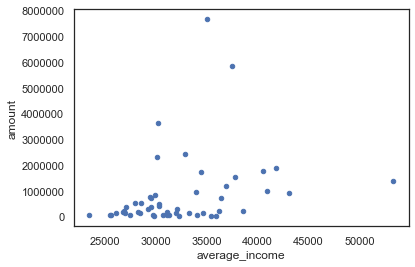

In [1452]:
demo_data.plot.scatter(x="average_income", y="amount")

In [1453]:
#pip install plotly

In [1454]:
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

In [1455]:
demo = pd.read_csv('demographics - raw_data (1).csv')
demo = demo.sort_values('Location').set_index('Location')
demo = demo.replace({'NSD': 0})

for i in demo.columns:
    demo[i] = demo[i].astype(float)
    
demo.head()

,"White, Non-Hispanic",Asian,Black,Hispanic,Total
Location,,,,,
Alabama,0.526,0.000,0.496,0.291,0.507
Alaska,0.603,0.000,0.000,0.000,0.528
Arizona,0.653,0.574,0.509,0.488,0.589
Arkansas,0.440,0.000,0.416,0.208,0.426
California,0.614,0.415,0.499,0.433,0.519


In [1456]:
demo.corr()

,"White, Non-Hispanic",Asian,Black,Hispanic,Total
"White, Non-Hispanic",1.000000,0.298730,0.045282,0.123442,0.871658
Asian,0.298730,1.000000,0.492456,0.589665,0.212472
Black,0.045282,0.492456,1.000000,0.400770,0.109167
Hispanic,0.123442,0.589665,0.400770,1.000000,-0.030190
Total,0.871658,0.212472,0.109167,-0.030190,1.000000


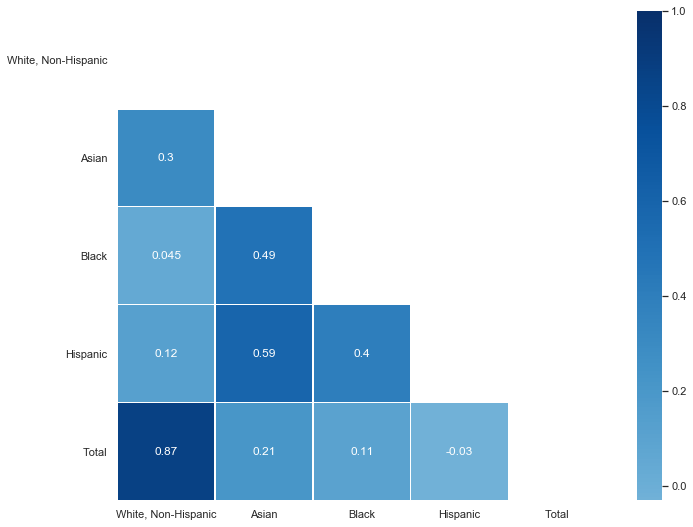

In [1457]:
# from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = demo.corr()#[['amount', 'amount_trump']]

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap="Blues", vmax=1, center=0,square=True, linewidths=.5, annot = True)

#### White, Non-Hispanic demographic visualization

In [1458]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')

fig = go.Figure(data=go.Choropleth(
    locations = df['code'], # Spatial coordinates
    z = demo['White, Non-Hispanic'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Proportion",
    zmax = max(demo['White, Non-Hispanic']),
))

fig.update_layout(
    title_text = 'Proportion of White Non-Hispanic Voters by State',
    geo_scope='usa',
)

fig.show()

#### Asian demographic visualization

In [1459]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')

fig = go.Figure(data=go.Choropleth(
    locations = df['code'], # Spatial coordinates
    z = demo['Asian'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Proportion",
    zmax = max(demo['White, Non-Hispanic']),
    zmin = 0
))

fig.update_layout(
    title_text = 'Proportion of Asian Voters by State',
    geo_scope='usa',
)

fig.show()

#### Black demographic visualization

In [1460]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')

fig = go.Figure(data=go.Choropleth(
    locations = df['code'], # Spatial coordinates
    z = demo['Black'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Proportion",
    zmax = max(demo['White, Non-Hispanic']),
    zmin = 0
    
))

fig.update_layout(
    title_text = 'Proportion of Black Voters by State',
    geo_scope='usa',
)

fig.show()

#### Hispanic visualization

In [1461]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')

fig = go.Figure(data=go.Choropleth(
    locations = df['code'], # Spatial coordinates
    z = demo['Hispanic'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Proportion",
    zmax = max(demo['White, Non-Hispanic']),
    zmin = 0
))

fig.update_layout(
    title_text = 'Proportion of Hispanic Voters by State',
    geo_scope='usa',
)

fig.show()

#### fec_trump visualization

In [1462]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')

fig = go.Figure(data=go.Choropleth(
    locations=df['code'], # Spatial coordinates
    z = demo_data['amount_trump'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Greens',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = '2011 US Agriculture Exports by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

#### correlation matrix

In [1463]:
demo_data.corr()#[['amount', 'amount_trump']]

,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,vote_pop,older_pop,per_older,per_vote,no_party,PVI,amount,amount_trump
per_black,1.000000,-0.106697,-0.452714,-0.454959,0.175171,0.162461,-0.021242,0.129315,0.139827,-0.234684,0.433406,0.197686,0.044183,0.172067,-0.002696
per_hisp,-0.106697,1.000000,-0.643081,-0.453786,0.111077,0.066612,0.139359,0.535567,0.499849,-0.218402,0.095951,0.422724,0.280766,0.489376,0.112234
per_white,-0.452714,-0.643081,1.000000,0.499271,-0.225969,-0.227952,-0.299782,-0.417270,-0.387200,0.337831,-0.339764,-0.550929,-0.407599,-0.444446,-0.064379
educ_hs,-0.454959,-0.453786,0.499271,1.000000,0.396163,0.399694,0.450768,-0.510008,-0.480089,0.107490,0.011944,-0.306684,0.039446,-0.382779,-0.039135
educ_coll,0.175171,0.111077,-0.225969,0.396163,1.000000,0.919931,0.816968,0.051610,0.029431,-0.271324,0.768654,0.171264,0.657400,0.276476,0.286717
average_income,0.162461,0.066612,-0.227952,0.399694,0.919931,1.000000,0.894979,0.048290,0.030165,-0.242707,0.790588,0.218326,0.630767,0.305785,0.268825
median_income,-0.021242,0.139359,-0.299782,0.450768,0.816968,0.894979,1.000000,0.071965,0.029604,-0.351335,0.599410,0.256427,0.579044,0.285828,0.259739
vote_pop,0.129315,0.535567,-0.417270,-0.510008,0.051610,0.048290,0.071965,1.000000,0.980175,-0.180314,0.183291,0.214682,0.260759,0.858827,0.207489
older_pop,0.139827,0.499849,-0.387200,-0.480089,0.029431,0.030165,0.029604,0.980175,1.000000,-0.065312,0.158135,0.188841,0.266698,0.858228,0.204933
per_older,-0.234684,-0.218402,0.337831,0.107490,-0.271324,-0.242707,-0.351335,-0.180314,-0.065312,1.000000,-0.377947,-0.069801,0.198523,-0.120084,-0.032716


There are weak correlations between all the demographics data to the fec contributions for each candidate.

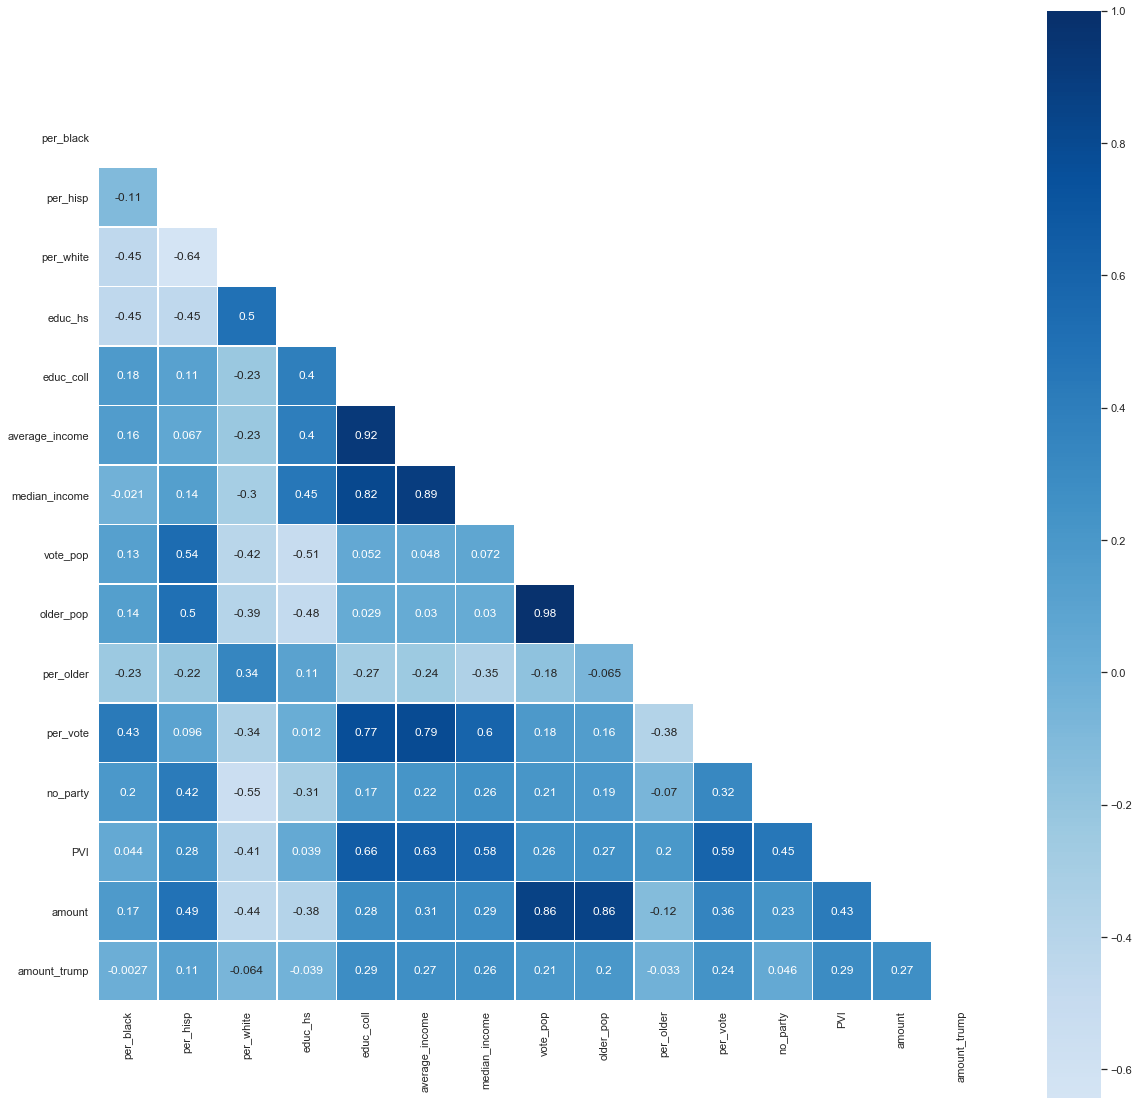

In [1464]:
# from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = demo_data.corr()#[['amount', 'amount_trump']]

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap="Blues", vmax=1, center=0,square=True, linewidths=.5, annot = True)

In [1465]:
giving = demo_data[["amount", "amount_trump"]].div(demo_data[["vote_pop", "older_pop"]].sum(1), axis=0)
giving.head()

,amount,amount_trump
state,,
Alabama,0.054218,0.202494
Alaska,0.069696,0.377822
Arizona,0.051191,0.305368
Arkansas,0.031376,0.153866
California,0.251148,0.310209


In [1466]:
demo_data[["amount", "amount_trump"]] = giving

In [1467]:
#pop_density
#Dem_adv
demo_data['pop_density'] = demo_data['pop_density'].str.replace(',','').astype(float)
demo_data['Dem_Adv'] = demo_data['Dem_Adv'].astype(float)
demo_data = demo_data.drop('District of Columbia', axis = 0)
demo_data.values

array([[      26.8   ,        4.4   ,       65.4   ,       85.8   ,
              24.9   ,    26846.    ,    48486.    ,       94.4   ,
         2981136.48  ,   828638.265 ,        0.169 ,        0.608 ,
             -15.    ,       15.    ,      -27.    ,        0.0542,
               0.2025],
       [       3.8   ,        7.2   ,       60.3   ,       92.7   ,
              29.2   ,    35874.    ,    76715.    ,        1.2   ,
          463067.985 ,    86322.31  ,        0.118 ,        0.633 ,
             -21.    ,       17.    ,      -15.    ,        0.0697,
               0.3778],
       [       5.1   ,       31.6   ,       54.4   ,       86.8   ,
              28.9   ,    29265.    ,    56213.    ,       56.3   ,
         4338115.332 ,  1273775.475 ,        0.175 ,        0.596 ,
              -2.    ,       18.    ,       -9.    ,        0.0512,
               0.3054],
       [      15.7   ,        7.7   ,       72.2   ,       86.2   ,
              22.6   ,    25635.    ,    457

In [1468]:
from scipy import cluster as sp_cluster
from sklearn import cluster, neighbors

In [1469]:
#Normalize a group of observations on a per feature basis.
clean_data = sp_cluster.vq.whiten(demo_data.values)
clean_data

array([[ 2.8162,  0.4261,  4.2035, 30.8143,  4.8975,  5.9334,  4.9441,
         0.3652,  0.6526,  0.7444,  9.0604, 47.8624, -1.0029,  6.5676,
        -1.3844,  0.288 ,  0.1199],
       [ 0.3993,  0.6972,  3.8757, 33.2924,  5.7433,  7.9287,  7.8226,
         0.0046,  0.1014,  0.0775,  6.3262, 49.8304, -1.4041,  7.4433,
        -0.7691,  0.3702,  0.2236],
       [ 0.5359,  3.0601,  3.4965, 31.1735,  5.6843,  6.468 ,  5.732 ,
         0.2178,  0.9496,  1.1442,  9.3821, 46.9177, -0.1337,  7.8811,
        -0.4615,  0.2719,  0.1808],
       [ 1.6498,  0.7457,  4.6405, 30.958 ,  4.4451,  5.6658,  4.6626,
         0.2166,  0.3944,  0.4609,  9.114 , 46.9965, -0.6018,  8.3189,
        -1.2306,  0.1666,  0.0911],
       [ 0.683 ,  3.8058,  2.3653, 29.7728,  6.5497,  7.7402,  7.263 ,
         0.9249,  5.4489,  5.0757,  7.6665, 49.5942,  1.4041,  8.3189,
         1.2306,  1.3339,  0.1836],
       [ 0.4834,  2.1014,  4.3642, 32.8255,  7.8871,  8.0483,  7.0166,
         0.1876,  0.8017,  0.7346,  7.6

In [1470]:
clean_data.var(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [1471]:
KNN = neighbors.NearestNeighbors(n_neighbors=7)
KNN.fit(clean_data)
KNN.kneighbors(clean_data[0].reshape(1,-1), return_distance=True)

(array([[0.    , 1.283 , 1.8028, 2.0372, 2.3057, 2.4864, 2.4938]]),
 array([[ 0, 39, 17, 41, 23, 16,  3]]))

In [1472]:
demo_data.index[0], demo_data.index[KNN.kneighbors(clean_data[0].reshape(1,-1), return_distance=True)[1][0]]

('Alabama',
 Index(['Alabama', 'South Carolina', 'Louisiana', 'Tennessee', 'Mississippi',
        'Kentucky', 'Arkansas'],
       dtype='object', name='state'))

In [1473]:
nearest_neighbor = {}
for i, state in enumerate(demo_data.index):
    neighborhood = KNN.kneighbors(clean_data[i].reshape(1,-1), return_distance=True)
    nearest_neighbor.update({state : (demo_data.index[neighborhood[1]],
                                     neighborhood[0])})

/Users/siddhipatel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/siddhipatel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/siddhipatel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/siddhipatel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

Support for multi-dimensio

In [1474]:
nearest_neighbor

{'Alabama': (array([['Alabama', 'South Carolina', 'Louisiana', 'Tennessee',
          'Mississippi', 'Kentucky', 'Arkansas']], dtype=object),
  array([[0.    , 1.283 , 1.8028, 2.0372, 2.3057, 2.4864, 2.4938]])),
 'Alaska': (array([['Alaska', 'North Dakota', 'Colorado', 'Kansas', 'Washington',
          'Utah', 'Minnesota']], dtype=object),
  array([[0.    , 3.4494, 3.9084, 4.0897, 4.1378, 4.1787, 4.3093]])),
 'Arizona': (array([['Arizona', 'Nevada', 'New Mexico', 'Oklahoma', 'Kansas',
          'North Carolina', 'Indiana']], dtype=object),
  array([[0.    , 2.9175, 2.9629, 3.2068, 3.4608, 3.489 , 3.522 ]])),
 'Arkansas': (array([['Arkansas', 'Tennessee', 'Oklahoma', 'Alabama', 'South Carolina',
          'Missouri', 'Indiana']], dtype=object),
  array([[0.    , 2.1176, 2.1767, 2.4938, 2.5191, 2.5666, 2.6562]])),
 'California': (array([['California', 'Texas', 'New York', 'Florida', 'Illinois',
          'Virginia', 'Washington']], dtype=object),
  array([[0.    , 4.4746, 4.896 , 6.0694,

In [1475]:
k_means = cluster.KMeans(n_clusters=5, n_init=50)
k_means.fit(clean_data)
values = k_means.cluster_centers_.squeeze()
labels = k_means.labels_
labels

array([2, 0, 2, 2, 1, 3, 3, 3, 1, 2, 3, 0, 3, 2, 0, 0, 2, 2, 0, 3, 4, 2,
       0, 2, 2, 0, 0, 2, 3, 3, 2, 1, 2, 0, 2, 2, 0, 2, 3, 2, 0, 2, 1, 0,
       3, 3, 3, 2, 0, 0], dtype=int32)

In [1476]:
clusters = sp_cluster.vq.kmeans(clean_data, 5)[0]
clusters

array([[ 0.3205,  0.9139,  5.0093, 32.9602,  5.8637,  6.9126,  6.3343,
         0.0671,  0.2099,  0.2083,  7.9949, 47.3704, -1.4459,  6.9507,
        -1.5318,  0.3015,  0.1614],
       [ 1.4133,  1.426 ,  3.8178, 32.2389,  7.2299,  8.3232,  7.3172,
         1.9513,  0.9456,  0.9888,  8.7789, 49.0432,  1.2203,  8.2095,
         0.8546,  1.6839,  0.7919],
       [ 0.9457,  3.4652,  2.9137, 30.6766,  5.6384,  6.6552,  5.8791,
         0.5054,  2.3139,  2.3702,  8.7655, 48.1117,  0.4012,  8.3189,
        -0.0085,  0.9246,  0.1949],
       [ 1.9636,  0.5707,  4.5368, 31.3099,  5.0903,  6.143 ,  5.1521,
         0.5178,  0.8315,  0.9148,  8.8817, 47.8571, -0.3299,  7.2973,
        -0.94  ,  0.332 ,  0.1236],
       [ 0.432 ,  0.5498,  5.419 , 33.0609,  6.3967,  7.2957,  6.1992,
         0.3502,  0.5348,  0.633 ,  9.6859, 48.0811,  0.364 ,  6.6649,
         0.0684,  0.6135,  0.1085]])

In [1477]:
def choose_group(data, clusters):
    """
    Return the index of the cluster to which the rows in data
    are "closest" (in the sense of the L2-norm)
    """
    data = data[:,None] # add an axis for broadcasting
    distances = data - clusters
    groups = []
    for row in distances:
        dists = map(np.linalg.norm, row)
        groups.append(np.argmin(list(dists)))
    return groups

In [1478]:
groups = choose_group(clean_data, clusters)
np.array(groups)

array([3, 0, 2, 3, 2, 1, 1, 1, 2, 3, 1, 0, 1, 3, 4, 0, 3, 3, 4, 1, 1, 3,
       4, 3, 3, 4, 0, 2, 4, 1, 2, 1, 3, 0, 3, 3, 4, 4, 1, 3, 0, 3, 2, 0,
       4, 1, 1, 3, 4, 0])

In [1479]:
demo_data["kmeans_group"] = groups
demo_data["kmeans_labels"] = labels

In [1480]:
for _, group in demo_data.groupby("kmeans_group"):
    group = group.index
    group.values.sort()
    print (group.values)

['Alaska' 'Idaho' 'Kansas' 'Nebraska' 'North Dakota' 'South Dakota' 'Utah'
 'Wyoming']
['Colorado' 'Connecticut' 'Delaware' 'Hawaii' 'Illinois' 'Maryland'
 'Massachusetts' 'New Jersey' 'New York' 'Rhode Island' 'Virginia'
 'Washington']
['Arizona' 'California' 'Florida' 'Nevada' 'New Mexico' 'Texas']
['Alabama' 'Arkansas' 'Georgia' 'Indiana' 'Kentucky' 'Louisiana'
 'Michigan' 'Mississippi' 'Missouri' 'North Carolina' 'Ohio' 'Oklahoma'
 'South Carolina' 'Tennessee' 'West Virginia']
['Iowa' 'Maine' 'Minnesota' 'Montana' 'New Hampshire' 'Oregon'
 'Pennsylvania' 'Vermont' 'Wisconsin']


In [1481]:
demo_data["kmeans_labels"] = labels
for _, group in demo_data.groupby("kmeans_labels"):
    group = group.index.copy()
    group.values.sort()
    print (group.values)

['Alaska' 'Idaho' 'Iowa' 'Kansas' 'Maine' 'Minnesota' 'Montana' 'Nebraska'
 'North Dakota' 'Oregon' 'South Dakota' 'Utah' 'Wisconsin' 'Wyoming']
['California' 'Florida' 'New York' 'Texas']
['Alabama' 'Arizona' 'Arkansas' 'Georgia' 'Indiana' 'Kentucky' 'Louisiana'
 'Michigan' 'Mississippi' 'Missouri' 'Nevada' 'New Mexico'
 'North Carolina' 'Ohio' 'Oklahoma' 'Pennsylvania' 'South Carolina'
 'Tennessee' 'West Virginia']
['Colorado' 'Connecticut' 'Delaware' 'Hawaii' 'Illinois' 'Maryland'
 'New Hampshire' 'New Jersey' 'Rhode Island' 'Vermont' 'Virginia'
 'Washington']
['Massachusetts']


In [1482]:
demo_data = demo_data.reset_index()
demo_data.head()

,state,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote,Dem_Adv,no_party,PVI,amount,amount_trump,kmeans_group,kmeans_labels
0,Alabama,26.8,4.4,65.4,85.8,24.9,26846.0,48486.0,94.4,2.981136e+06,828638.265,0.169,0.608,-15.0,15.0,-27.0,0.054218,0.202494,3,2
1,Alaska,3.8,7.2,60.3,92.7,29.2,35874.0,76715.0,1.2,4.630680e+05,86322.310,0.118,0.633,-21.0,17.0,-15.0,0.069696,0.377822,0,0
2,Arizona,5.1,31.6,54.4,86.8,28.9,29265.0,56213.0,56.3,4.338115e+06,1273775.475,0.175,0.596,-2.0,18.0,-9.0,0.051191,0.305368,2,2
3,Arkansas,15.7,7.7,72.2,86.2,22.6,25635.0,45726.0,56.0,1.801629e+06,513026.680,0.170,0.597,-9.0,19.0,-24.0,0.031376,0.153866,3,2
4,California,6.5,39.3,36.8,82.9,33.3,35021.0,71228.0,239.1,2.489270e+07,5650247.889,0.143,0.630,21.0,19.0,24.0,0.251148,0.310209,2,1


In [1483]:
polls.state.replace(states_abbrev_dict, inplace=True)
polls = polls.merge(demo_data[["state", "kmeans_labels"]], on="state")
polls.head()

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,Bias,Mean-Reverted Bias.1,House Effect,age_weight,recency_weight,pollster_weight,sample_size_weight,weighted_average,spread,kmeans_labels
0,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506,1.466921,1.161794,DEM 2.0,1
1,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506,1.466921,1.161794,DEM 2.0,1
2,118575,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.667653,0.182681,DEM 2.0,1
3,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.665663,0.182137,DEM 2.0,1
4,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.665663,0.182137,DEM 2.0,1


In [1484]:
kmeans_groups = polls.groupby("kmeans_labels")
kmeans_groups.groups.keys()

dict_keys([0, 1, 2, 3, 4])

In [1485]:
group = kmeans_groups.get_group(list(kmeans_groups.groups.keys())[2])
group

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,Bias,Mean-Reverted Bias.1,House Effect,age_weight,recency_weight,pollster_weight,sample_size_weight,weighted_average,spread,kmeans_labels
60,120728,65060,2020,Michigan,383,Public Policy Polling,338,Progress Michigan,Public Policy Polling,263.0,...,D +0.3,D +0.3,D +1.0,0.0,0.911722,0.715850,0.822155,0.536585,DEM 0,2
61,120728,65060,2020,Michigan,383,Public Policy Polling,338,Progress Michigan,Public Policy Polling,263.0,...,D +0.3,D +0.3,D +1.0,0.0,0.911722,0.715850,0.822155,0.536585,DEM 0,2
62,119814,64766,2020,Michigan,568,YouGov,1213,Yahoo News,YouGov,391.0,...,D +0.3,D +0.3,D +0.3,0.0,0.523647,0.692186,0.612738,0.222094,DEM 2.0,2
63,119814,64766,2020,Michigan,568,YouGov,1213,Yahoo News,YouGov,391.0,...,D +0.3,D +0.3,D +0.3,0.0,0.523647,0.692186,0.612738,0.222094,DEM 2.0,2
64,119815,64766,2020,Michigan,568,YouGov,1213,Yahoo News,YouGov,391.0,...,D +0.3,D +0.3,D +0.3,0.0,0.523647,0.692186,0.612738,0.222094,DEM 2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,98031,58473,2020,Kentucky,801,Gravis Marketing,NaN,NaN,Gravis Marketing,124.0,...,D +0.9,D +0.6,R +0.9,0.0,0.001023,0.550201,0.701093,0.000395,DEM 0,2
941,98032,58473,2020,Kentucky,801,Gravis Marketing,NaN,NaN,Gravis Marketing,124.0,...,D +0.9,D +0.6,R +0.9,0.0,0.001023,0.550201,0.701093,0.000395,DEM 0,2
942,98032,58473,2020,Kentucky,801,Gravis Marketing,NaN,NaN,Gravis Marketing,124.0,...,D +0.9,D +0.6,R +0.9,0.0,0.001023,0.550201,0.701093,0.000395,DEM 0,2
943,98033,58473,2020,Kentucky,801,Gravis Marketing,NaN,NaN,Gravis Marketing,124.0,...,D +0.9,D +0.6,R +0.9,0.0,0.001023,0.550201,0.701093,0.000395,DEM 0,2


In [1486]:
group.state.unique()

array(['Michigan', 'Arizona', 'Ohio', 'North Carolina', 'Pennsylvania',
       'South Carolina', 'New Mexico', 'Nevada', 'Georgia', 'Mississippi',
       'Alabama', 'Tennessee', 'Missouri', 'Oklahoma', 'Kentucky'],
      dtype=object)

In [1487]:
rep_points = []
dem_points = []
for i in group['state'].unique():
    start = group[group['state'] == i]
    for j in start['pollster'].unique():
        mid = start[start['pollster'] == j]
        mid = mid.sort_values(by = 'end_date').reset_index(drop=True)
        rep = mid[mid['candidate_party'] == 'REP'].reset_index(drop=True)
        dem = mid[mid['candidate_party'] == 'DEM'].reset_index(drop=True)
        if len(rep) > 1:
            rep_points.append([i,j,((rep.loc[0]['pct'] - rep.loc[len(rep)-1]['pct'])*(-1))])
        elif len(rep) == 1:
            rep_points.append([i,j,0])
        if len(dem) > 1:
            dem_points.append([i,j,(dem.loc[0]['pct'] - dem.loc[len(dem)-1]['pct'])])
        elif len(dem) == 1:
            dem_points.append([i,j,0])

In [1488]:
loess_df = group.copy()
loess_df['spread'] = "NAN " + str(0)

for i in rep_points: 
    loess_df.loc[(loess_df.state == i[0]) & (loess_df['pollster'] == i[1]),'spread'] = "REP " + str(i[2])
    
for i in dem_points: 
    loess_df.loc[(loess_df.state == i[0]) & (loess_df['pollster'] == i[1]),'spread'] = "DEM " + str(i[2])

loess_df = loess_df.reset_index(drop=True)

In [1489]:
def edit_tick_label(tick_val, tick_pos):
    if 'DEM' in tick_val:
        text = tick_val.replace("DEM", "BIDEN")
    else:
        text = tick_val.replace("REP", "TRUMP")
    return text

In [1490]:
def number(val):
    val = val[4:]
    return val

In [1491]:
from matplotlib.ticker import FuncFormatter

fig, axes = plt.subplots(figsize=(12,8))

data = loess_df[["end_date", "spread"]]
data = pd.concat((data, loess_df_1[["end_date", "spread"]])).reset_index(drop=True)
    
dates = pd.to_datetime(data.end_date)

data['spread'] = data['spread'].apply(lambda x: number(x))
data['spread'] = data['spread'].astype(float)

loess_res = sm.nonparametric.lowess(data.spread.values, dates, frac=0.2, it=100)

axes.scatter(dates, data["spread"])
axes.plot(dates, loess_res[:,1], color='r', lw = 0.5)
axes.yaxis.get_major_locator().set_params(nbins=20)
axes.yaxis.set_major_formatter(FuncFormatter(edit_tick_label))
axes.grid(False, axis='y')
axes.margins(0, .05)

/Users/siddhipatel/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning:

invalid value encountered in greater_equal



TypeError: argument of type 'numpy.float64' is not iterable

<Figure size 864x576 with 1 Axes>

In [1492]:
loess_res[-7:,1].mean()

nan

In [1493]:
trends = []
for i,group in kmeans_groups:
    data = group[["end_date", "spread"]]
    data = pd.concat((data, polls[["end_date", "spread"]]))
    
    dates = pd.DatetimeIndex(data.end_date).asi8
    
    data['spread'] = data['spread'].apply(lambda x: number(x))
    data['spread'] = data['spread'].astype(float)

    loess_res = sm.nonparametric.lowess(data.spread.values, dates, frac=.5, it=3)
    
    states = group.state.unique()
    
    for state in states:
        trends.append([state, loess_res[-7:,1].mean()])

In [1494]:
trends

[['Wisconsin', -0.05809175483446483],
 ['Kansas', -0.05809175483446483],
 ['Maine', -0.05809175483446483],
 ['Iowa', -0.05809175483446483],
 ['North Dakota', -0.05809175483446483],
 ['Minnesota', -0.05809175483446483],
 ['Alaska', -0.05809175483446483],
 ['Utah', -0.05809175483446483],
 ['Florida', -0.1821533862794576],
 ['California', -0.1821533862794576],
 ['Texas', -0.1821533862794576],
 ['New York', -0.1821533862794576],
 ['Michigan', 0.21775582336304433],
 ['Arizona', 0.21775582336304433],
 ['Ohio', 0.21775582336304433],
 ['North Carolina', 0.21775582336304433],
 ['Pennsylvania', 0.21775582336304433],
 ['South Carolina', 0.21775582336304433],
 ['New Mexico', 0.21775582336304433],
 ['Nevada', 0.21775582336304433],
 ['Georgia', 0.21775582336304433],
 ['Mississippi', 0.21775582336304433],
 ['Alabama', 0.21775582336304433],
 ['Tennessee', 0.21775582336304433],
 ['Missouri', 0.21775582336304433],
 ['Oklahoma', 0.21775582336304433],
 ['Kentucky', 0.21775582336304433],
 ['Washington', -0

In [1495]:
list(demo_data[demo_data['state'] == "Arizona"]['PVI'])[0]

-9.0

In [1496]:
for i in trends:
    i[1] = i[1] + list(demo_data[demo_data['state'] == i[0]]['PVI'])[0]

## Snapshot

In [1497]:
state_polls.name = "poll"
state_polls

state      pollster                                 
Alabama    Mason-Dixon Polling & Research Inc.  1350    0.129619
                                                1351    0.129619
                                                1352    0.129619
                                                1353    0.129619
                                                1354    0.129619
                                                          ...   
Wisconsin  Zogby Interactive/JZ Analytics       1533    0.000100
                                                1534    0.000100
                                                1535    0.000100
                                                1536    0.000100
                                                1537    0.000100
Name: poll, Length: 965, dtype: float64

In [1498]:
state_polls = state_polls.reset_index()
state_polls.state = state_polls.state.replace(states_abbrev_dict)
state_polls = state_polls.drop(['level_2'], axis = 1)

In [1499]:
state_polls.groupby('state').mean()

,poll
state,
Alabama,0.129619
Alaska,0.000864
Arizona,0.106160
California,0.130359
Colorado,0.003154
Delaware,0.057268
Florida,0.101702
Georgia,0.056355
Iowa,0.061584


In [1500]:
#trends.name = "poll"
trends = pd.DataFrame(data = trends)
trends = trends.rename({0: 'state', 1: 'trend'}, axis='columns')
trends.head()

,state,trend
0,Wisconsin,-1.058092
1,Kansas,-23.058092
2,Maine,4.941908
3,Iowa,-6.058092
4,North Dakota,-33.058092


In [1501]:
polls = state_polls.merge(trends, on = 'state')
polls

,state,pollster,poll,trend
0,Alabama,Mason-Dixon Polling & Research Inc.,0.129619,-26.782244
1,Alabama,Mason-Dixon Polling & Research Inc.,0.129619,-26.782244
2,Alabama,Mason-Dixon Polling & Research Inc.,0.129619,-26.782244
3,Alabama,Mason-Dixon Polling & Research Inc.,0.129619,-26.782244
4,Alabama,Mason-Dixon Polling & Research Inc.,0.129619,-26.782244
...,...,...,...,...
948,Wisconsin,Zogby Interactive/JZ Analytics,0.000100,-1.058092
949,Wisconsin,Zogby Interactive/JZ Analytics,0.000100,-1.058092
950,Wisconsin,Zogby Interactive/JZ Analytics,0.000100,-1.058092
951,Wisconsin,Zogby Interactive/JZ Analytics,0.000100,-1.058092


In [1502]:
polls['poll'] = polls['poll'] * polls['trend']
polls = polls.drop('trend', axis = 1)

In [1503]:
polls

,state,pollster,poll
0,Alabama,Mason-Dixon Polling & Research Inc.,-3.471487
1,Alabama,Mason-Dixon Polling & Research Inc.,-3.471487
2,Alabama,Mason-Dixon Polling & Research Inc.,-3.471487
3,Alabama,Mason-Dixon Polling & Research Inc.,-3.471487
4,Alabama,Mason-Dixon Polling & Research Inc.,-3.471487
...,...,...,...
948,Wisconsin,Zogby Interactive/JZ Analytics,-0.000106
949,Wisconsin,Zogby Interactive/JZ Analytics,-0.000106
950,Wisconsin,Zogby Interactive/JZ Analytics,-0.000106
951,Wisconsin,Zogby Interactive/JZ Analytics,-0.000106


In [1504]:
results = polls.groupby("state").mean()
results

,poll
state,
Alabama,-3.471487
Alaska,-0.013007
Arizona,-0.932319
California,3.104873
Colorado,0.003090
Delaware,0.800583
Florida,-0.527036
Georgia,-0.663988
Iowa,-0.373081


In [1505]:
electoral_votes = pd.read_csv('https://raw.githubusercontent.com/jseabold/538model/master/data/electoral_votes.csv')
electoral_votes.head()

,State,Votes
0,California,55
1,Texas,38
2,New York,29
3,Florida,29
4,Illinois,20


In [1506]:
results = results.reset_index()
results["biden"] = 0
results["trump"] = 0
results.loc[(results["poll"] > 0), "biden"] = 1
results.loc[(results["poll"] < 0), "trump"] = 1
results

,state,poll,biden,trump
0,Alabama,-3.471487,0,1
1,Alaska,-0.013007,0,1
2,Arizona,-0.932319,0,1
3,California,3.104873,1,0
4,Colorado,0.003090,1,0
5,Delaware,0.800583,1,0
6,Florida,-0.527036,0,1
7,Georgia,-0.663988,0,1
8,Iowa,-0.373081,0,1
9,Kansas,-4.986691,0,1


In [1507]:
results = results.merge(electoral_votes, left_on = 'state', right_on = 'State')
results

,state,poll,biden,trump,State,Votes
0,Alabama,-3.471487,0,1,Alabama,9
1,Alaska,-0.013007,0,1,Alaska,3
2,Arizona,-0.932319,0,1,Arizona,11
3,California,3.104873,1,0,California,55
4,Colorado,0.003090,1,0,Colorado,9
5,Delaware,0.800583,1,0,Delaware,3
6,Florida,-0.527036,0,1,Florida,29
7,Georgia,-0.663988,0,1,Georgia,16
8,Iowa,-0.373081,0,1,Iowa,6
9,Kansas,-4.986691,0,1,Kansas,6


In [1508]:
results["Votes"].mul(results["biden"]).sum()

168

In [1509]:
results["Votes"].mul(results["trump"]).sum()

264